In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv('weather.csv')

# Convert categorical features to numerical
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

# Identify the categorical columns you want to one-hot encode
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_cols])

# Get the feature names for the new encoded columns
feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Separate features (X) and target (y)
X = df_encoded.drop(columns = ['Temp3pm'])# all columns except the rain tmr
y = df_encoded['Temp3pm'] # last

# Handle missing values
X = X.dropna()
y = y.loc[X.index] # y only has rows corresponding to row indices of X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('y_pred = ' , y_pred)
print('y_test = ' , y_test.to_numpy())
plt.plot(y_pred, '--', label='Model')
plt.plot(y_test.to_numpy(), label='Data')
plt.legend()
plt.show()

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# Print the feature importances
print("\nFeature Importances:")
print(feature_importances)

FileNotFoundError: [Errno 2] No such file or directory: 'weather.csv'

# Neural Operators

Quinn Heng-Martin, Brandt Benfield; Colorado State University 2025

## Introduction

Neural Networks (NNs) are often described as universal function approximators, mapping an arbitrary set of inputs to outputs. This is certainly a very useful task, however in physics and engineering we are often interested in examining systems that produce different functions characterized by the same underlying behavior, depending on some initial or boundary conditions. It is the underlying behaviour we are interested in, not the particular function. That is, we seek to find mappings from functions to functions. This actually expands our problem space more than one might think: since there are an infinite number of functions that are completely unrelated (the family $\delta(x-x_0)$ for example), our parameter space is actually *infinite dimensional*. This might seem an insurmountable challenge, but NNs provide a nice starting point. This function-to-function mapping is precisely what an operator is, so a NN-derived architecture to solve these problems, naturally, is called a Neural Operator (NO). NOs were originally proposed by researchers at Caltech in 2020 [[1](https://arxiv.org/abs/2010.08895)] [[2](https://arxiv.org/abs/2108.08481)] - We seek to use the NO library published by the this team ([arxiv](https://arxiv.org/abs/2412.10354)) to create short- to medium-term weather forecasts for Colorado (a conveniently rectangular state).

### On the Technical Details
 Neural operators(NO) take an input function a(x) and transforms it through a series of lifting layers, followed by T Fourier layers, then a projection layer, ultimately outputting the solution function u(x). This sequential processing allows the NO to learn the mapping between infinite-dimensional function spaces.[[2](https://arxiv.org/pdf/2108.08481)]

The internal structure of a single Fourier layer is as so. It receives an input function v(x). The core of the Fourier layer lies in its application of the Fourier transform (F) to the input, moving the function from the physical space to the Fourier space. In this spectral domain the different frequency modes of the function are represented. A linear operation with a filter kernel is then performed. This operation allows the network to selectively modify or emphasize certain frequency components. Subsequently, an inverse Fourier transform (inv(f)) brings the processed function back to the physical space. In parallel to this spectral pathway, the input function v(x) also undergoes a point-wise linear transformation. The outputs of the spectral pathway (after the inverse Fourier transform) and the point-wise transformation are then added together. Finally, a non-linear activation function σ is applied to the summed result preparing the output for the next layer in the sequence. By stacking multiple such Fourier layers the FNO can learn complex mappings between function spaces. Making it particularly effective for solving partial differential equations and other tasks involving continuous functions. The key innovation of FNOs lies in performing the integral operator in the Fourier domain through efficient element-wise multiplication. Which can be implemented using Fast Fourier Transforms, leading to computational efficiency and the ability to handle high-dimensional input and output spaces.[[2](https://arxiv.org/pdf/2108.08481)]


### The Gameplan (Methodology):

All training data is taken from the [
ERA5 hourly data on single levels from 1940 to present](https://doi.org/10.24381/cds.adbb2d47) and converted to CSV format for communicative/hand-in purposes.

In [ ]:
# Neural Operator install Options:
#!pip install neuraloperator
#!pip install git+https://github.com/neuraloperator/neuraloperator.git
#!conda install conda-forge::neuraloperator

from neuralop.training import Trainer
from neuralop.models import FNO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation
class WeatherTensorDataset(Dataset):          # This class is a custom dataset loader that will load preprocessed
    def __init__(self, data_path):            # weather data (saved as a .pt file) into PyTorch’s data pipeline.
        self.samples = torch.load(data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return {'x': self.samples[idx][0], 'y': self.samples[idx][1]}

First, let's load up our data and get a look at it:

,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
0,2022-01-01 03:00:00,41.0,-109.0,0.694458,-0.103119,261.02032,262.44580,77215.0,0.223984,0.018707
1,2022-01-01 03:00:00,41.0,-108.5,0.498169,0.364655,260.49298,261.94580,77910.0,0.170273,0.116364
2,2022-01-01 03:00:00,41.0,-108.0,-0.283081,0.928131,260.55157,262.17627,77852.0,-0.130508,0.344879
3,2022-01-01 03:00:00,41.0,-107.5,-1.179565,1.212311,259.16290,261.19970,75851.0,-0.657852,0.766754
4,2022-01-01 03:00:00,41.0,-107.0,-0.895386,0.902740,258.49884,260.38330,73532.0,-0.682266,0.731598


,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
44823,2022-03-25 03:00:00,41.0,-107.5,-0.174744,1.760712,269.31372,274.34520,77661.44,0.036697,0.802505
2266,2022-01-05 03:00:00,37.5,-108.5,-0.914658,-0.510742,262.20117,266.45532,78367.19,-0.451141,-0.442108
77895,2022-05-25 09:00:00,41.0,-109.0,0.972885,-0.805618,268.81738,276.64038,78832.94,0.261307,-0.204178
134572,2022-09-07 03:00:00,37.5,-105.5,-1.642929,0.869400,278.10352,289.40283,74784.06,-0.476227,0.285019
71059,2022-05-12 15:00:00,39.5,-107.0,4.492264,2.810837,262.27002,274.18140,72429.25,4.519379,2.827820


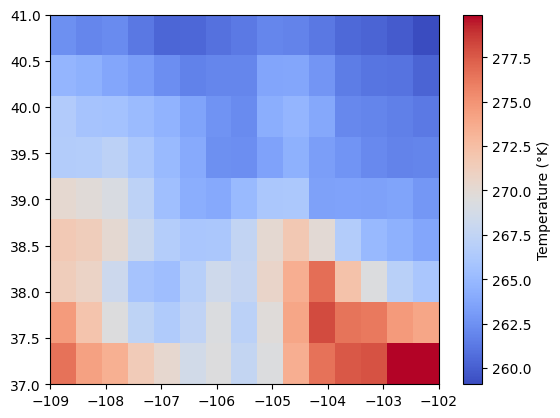

In [ ]:
df = pd.read_csv('data2022/accum_data.csv')
df.valid_time = df.valid_time.astype('datetime64[s]')

W = len(df.longitude.unique())
H = len(df.latitude.unique())
T = len(df.valid_time.unique())
extent = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())

display(df.head())
display(df.sample(5))
initial_temp = (df[df.valid_time=='2022-01-01 3:00:00']
                .pivot(index='latitude',columns='longitude',
                       values='surface_temperature')
                .sort_index(ascending=False)
               )
def plot(data, label='Temperature (°K)', title=None):
  plt.imshow(data, aspect=W/H, extent=extent, cmap='coolwarm')  # or 'viridis' if you prefer
  plt.colorbar(label=label)
  if title:
      plt.title(title)
  #plt.xlabel(None)
  #plt.ylabel(None)
  plt.show()
plot(initial_temp)

Nice! next up, a neural operator will benefit from knowing the coordinates of it's data, including time. Let's make a float-valued time that a NO can understand:

In [ ]:
# Assign each time a timestep float
times = df['valid_time'].sort_values().unique()
dt = times[1]-times[0] # The model will see a day that is 24H/dt ticks long
df['time'] = (df['valid_time']-times[0])/dt
(times-times[0])/dt

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.457e+03, 1.458e+03,
       1.459e+03])

In [ ]:
# Re-package everything into 3d data

# Drop valid_time and move all coordinate channels to the end as the model expects: (there's definitely a more elegant way to do this..)
channels = list(df.columns.drop(['valid_time', 'latitude', 'longitude']))+['latitude','longitude']
C = len(channels)
data_array = (df[channels]
              .sort_values(['time', 'latitude', 'longitude'])
              .values
              .reshape([T,H,W,C])
             )
print(f'{data_array.shape = } = (T, H, W, C)')

data_array.shape = (1460, 9, 15, 10) = (T, H, W, C)


As a sanity check, let's show that inital temperature distribution again:

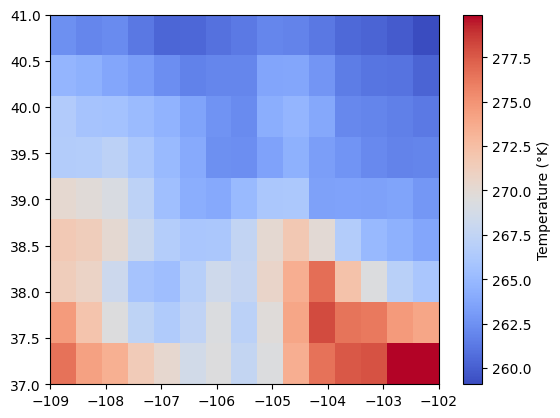

In [ ]:
plot(data_array[0,::-1,:,3].astype(float))

Looking good! Brandt, could you figure out how to add a temperature scale to this?

In [ ]:
data = (torch.tensor(data_array, dtype=torch.float32)
        .transpose(0,3))  # Place channels up front to appease neuralop

## First Run:

In [ ]:
# Make some input/output pairs:

# TODO apparently i was thinking in two directions at some point, this needs looked at

data = data
input_tensor = data[:,:,:,:-1]
input_tensors = input_tensor.split(split_size=1,dim=3)

In [ ]:
#output_tensor = data[:,:,:,1:]  # Try to predict the next timestep
output_tensor = data[[3],:,:,1:]  # Just try to predict the next temp

In [ ]:
output_tensors = output_tensor.split(split_size=1,dim=3)

# Split data into pairs of timesteps. Given one timestep, the model should predict the next one
from itertools import pairwise
chunks = map(torch.squeeze, data.split(1,dim=3))
chunks = tuple(pairwise(chunks))
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(1,dim=3)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(1,dim=3))))
print(f'{chunks[0][1].shape = }')
torch.save(chunks, 'weather_chunks.pt')
tuple(pairwise(torch.tensor((1,2,3,4,5,6)).split(1, dim=0)))  # Illustration of split and pairwise working together

chunks[0][1].shape = torch.Size([1, 9, 15])


((tensor([1]), tensor([2])),
 (tensor([2]), tensor([3])),
 (tensor([3]), tensor([4])),
 (tensor([4]), tensor([5])),
 (tensor([5]), tensor([6])))

In [ ]:
# Load and clean the CSV file
df = pd.read_csv('accum_data.csv')

# Grid creation
times = sorted(df['valid_time'].unique()) # Get unique times

input_vars = ['u10', 'v10', 'surface_pressure', 'u10n', 'v10n']
output_var = 'surface_temperature'

grids = []

lat_vals = sorted(df['latitude'].unique()) # Unique lat
lon_vals = sorted(df['longitude'].unique()) # Unique long

H = len(lat_vals) # Height (number of latitude values)
W = len(lon_vals)  # Width (number of longitude values)

# Process the data for each time step
for time in tqdm(times):   # tqdm(times) progress bar for visualization
    slice_df = df[df['valid_time'] == time] # Get data for the current time step


    # Build 2D grid for each input variable
    input_channels = [slice_df
                      .pivot(index='latitude', columns='longitude', values=var)
                      .to_numpy()
                      for var in input_vars
                     ]
    # for var in input_vars:
    #     pivot = slice_df.pivot(index='latitude', columns='longitude', values=var)
    #     grid = pivot.to_numpy() # Creates a 2D grid using pandas
    #     input_channels.append(grid)

    # Build target grid
    target_pivot = slice_df.pivot(index='latitude', columns='longitude', values=output_var)
    target_grid = target_pivot.to_numpy()

    # Stack into tensors
    input_tensor = torch.tensor(np.stack(input_channels), dtype=torch.float32)  # Shape: [C, H, W]  (C is the # of input variables, H is the # of lat points, and W is the # of long points)
    target_tensor = torch.tensor(target_grid[np.newaxis, :, :], dtype=torch.float32)  # Shape: [1, H, W]

    grids.append((input_tensor, target_tensor))

# Save the dataset to a file
torch.save(grids, 'weather_dataset.pt')  # List of (input, target) pairs

100%|██████████| 1460/1460 [00:43<00:00, 33.50it/s]


In [ ]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_dataset.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = 5 # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=2, device=device)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}
full_dataset[0]['x'].shape, full_dataset[0]['y'].shape

(torch.Size([5, 9, 15]), torch.Size([1, 9, 15]))

In [ ]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_chunks.pt')
full_dataset[0]['x'].shape

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model Setup
in_channels = C # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=5, device=device, eval_interval=1, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

In [ ]:
train_dataset[0]['x'].shape, train_dataset[0]['y'].shape

(torch.Size([10, 9, 15]), torch.Size([1, 9, 15]))

In [ ]:
# Train the model
trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 1167 samples
Testing on [292] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([1, 1, 9, 15])
[0] time=41.97, avg_loss=0.0786, train_err=0.0786
Eval: test_l2=0.0496
[1] time=42.91, avg_loss=0.0577, train_err=0.0577
Eval: test_l2=0.0534
[2] time=43.53, avg_loss=0.0525, train_err=0.0525
Eval: test_l2=0.0544
[3] time=43.47, avg_loss=0.0511, train_err=0.0511
Eval: test_l2=0.1035
[4] time=43.17, avg_loss=0.0493, train_err=0.0493
Eval: test_l2=0.0375


{'train_err': 0.0492658580069996,
 'avg_loss': 0.0492658580069996,
 'avg_lasso_loss': None,
 'epoch_train_time': 43.17167571600021,
 'test_l2': tensor(0.0375)}

Strangely, I only get this NNPACK! warning occasionally. It seems to lead to about a 3x slowdown. Painful, considering how long training is taking already...

Looking at the losses, it looks like we really only needed a couple of epochs to train! So how's it look?

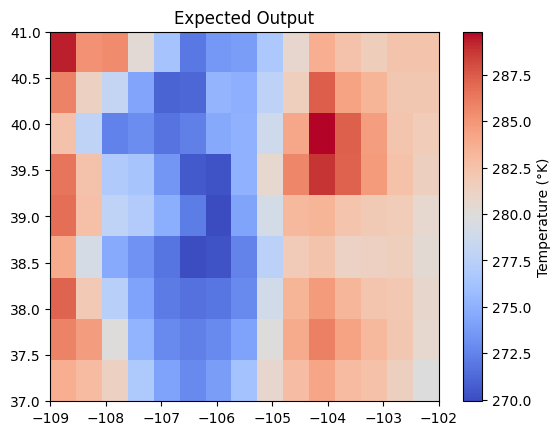

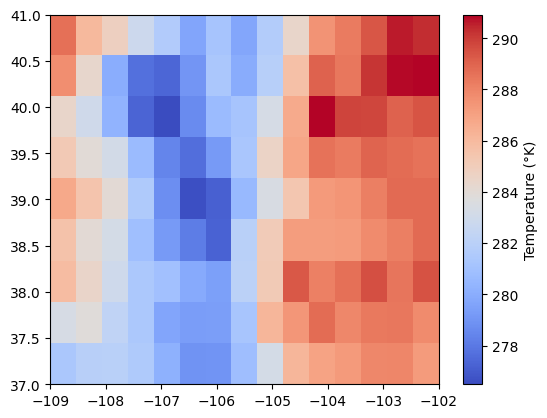

In [ ]:
x_example = test_dataset[73]['x'].unsqueeze(0)
y_expected = test_dataset[73]['y']
y_predicted = model(x_example)

plt.imshow(y_expected.squeeze(), cmap='coolwarm', aspect=W/H, extent=extent)
plt.colorbar(label='Temperature (°K)')
plt.title('Expected Output')
plt.show()

plot(y_predicted.squeeze().detach().numpy())
plt.show()

In [ ]:
%timeit y_predicted = model(x_example)

10.2 ms ± 289 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not terrible... let's crank it up!

## Second Go Round

In [ ]:
# Dataset Splitting
input_tensor = data[:,:,:,:-1]
output_tensor = data[[3],:,:,1:]  # Try to predict all variables at the next timestep

time_dim = 3
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(1, dim=time_dim)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(1, dim=time_dim))))
torch.save(chunks, 'weather_chunks2.pt')
full_dataset = WeatherTensorDataset('weather_chunks2.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_dataset[0]['y'].shape # C x T x H x W, where T is the number of observation times

torch.Size([1, 9, 15])

In [ ]:
# Model Setup

in_channels = train_dataset[0]['x'].shape[0] # # of input
out_channels = train_dataset[0]['y'].shape[0] # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=3, eval_interval=1, device=device, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 1167 samples
Testing on [292] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([1, 1, 9, 15])
[0] time=44.37, avg_loss=0.0812, train_err=0.0812
Eval: test_l2=0.0395
[1] time=43.43, avg_loss=0.0594, train_err=0.0594
Eval: test_l2=0.0427
[2] time=42.74, avg_loss=0.0528, train_err=0.0528
Eval: test_l2=0.0373


{'train_err': 0.05279590932200659,
 'avg_loss': 0.05279590932200659,
 'avg_lasso_loss': None,
 'epoch_train_time': 42.74479609700029,
 'test_l2': tensor(0.0373)}

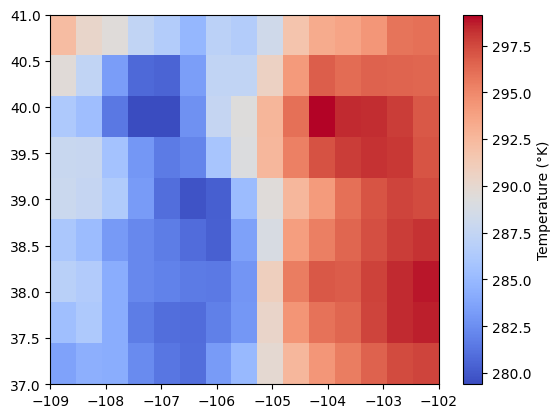

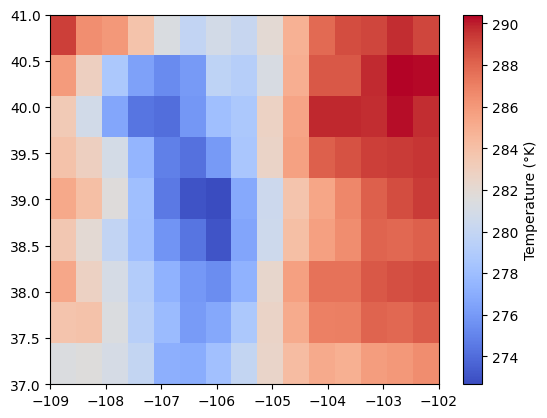

torch.Size([1, 1, 9, 15])

In [ ]:
look_at=42
x_example = test_dataset[look_at]['x'].unsqueeze(0)
y_expected = test_dataset[look_at]['y']
y_predicted = model(x_example)
plot(y_expected[0,:,:])
plt.show()
plot(y_predicted.squeeze(0)[0,:,:].detach().numpy())
plt.show()
y_predicted.shape

Well that's.... worse... let's look at the rest of the channels?

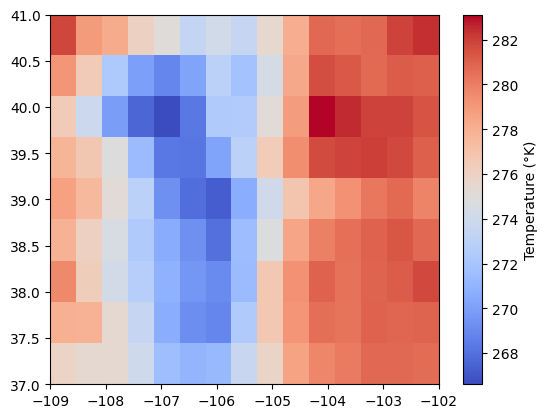

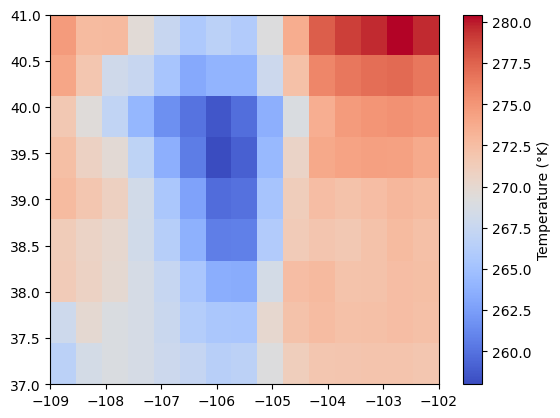

In [ ]:
#out = model(test_dataset[0]['x'].unsqueeze(0)).squeeze()
#for i in range(out.shape[0]):
#    prediction = out[i,:,:]
#    test = test_dataset[0]['y'][i,:,:]
#    plot(prediction.detach().numpy())
#    plt.show()
#    plot(test)
#    plt.show()
# not sure how to convert to make it work in the same way


out = model(test_dataset[0]['x'].unsqueeze(0))
for i in range(out.shape[0]):
    prediction = out[0,i,:,:]
    test = test_dataset[0]['y'][i,:,:]
    plot(prediction.detach().numpy())
    plt.show()
    plot(test)
    plt.show()

Something is **very** wrong here.

In [ ]:
## Appendix: Data Conversion

In [ ]:
#please don't remove I need them every time I pull from main
#!apt-get install -y libeccodes0 libeccodes-dev
#!pip install cfgrib xarray

In [ ]:
import xarray as xr

# Load GRIB (or grb) file (from what I found they act the same)
ds = xr.open_dataset('CaribbeanWeatherTest.wind.7days.grb', engine='cfgrib')

# Inspect the dataset
print(ds)
ds.variables.keys()

<xarray.Dataset> Size: 158kB
Dimensions:            (step: 27, latitude: 22, longitude: 33)
Coordinates:
    time               datetime64[ns] 8B ...
  * step               (step) timedelta64[ns] 216B 0 days 06:00:00 ... 6 days...
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 176B 9.0 10.0 11.0 ... 28.0 29.0 30.0
  * longitude          (longitude) float64 264B 263.0 264.2 ... 301.8 303.0
    valid_time         (step) datetime64[ns] 216B ...
Data variables:
    u10                (step, latitude, longitude) float32 78kB ...
    v10                (step, latitude, longitude) float32 78kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-05-05T19:30 GRIB to CDM+CF via cfgrib-0.9.1...


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


KeysView(Frozen({'time': <xarray.Variable ()> Size: 8B
[1 values with dtype=datetime64[ns]]
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time, 'step': <xarray.IndexVariable 'step' (step: 27)> Size: 216B
array([ 21600000000000,  43200000000000,  64800000000000,  86400000000000,
       108000000000000, 129600000000000, 151200000000000, 172800000000000,
       194400000000000, 216000000000000, 237600000000000, 259200000000000,
       280800000000000, 302400000000000, 324000000000000, 345600000000000,
       367200000000000, 388800000000000, 410400000000000, 432000000000000,
       453600000000000, 475200000000000, 496800000000000, 518400000000000,
       540000000000000, 561600000000000, 583200000000000],
      dtype='timedelta64[ns]')
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period, 'heightAboveGround': <xarray.Variable ()> Size: 8B
[1 values with dtype=float64]
Attributes:
    long_

In [ ]:
# For example, if 'time' is a variable:
time = ds['time']
print(time)

<xarray.DataArray 'time' ()> Size: 8B
[1 values with dtype=datetime64[ns]]
Coordinates:
    time               datetime64[ns] 8B ...
    heightAboveGround  float64 8B ...
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time
